In [1]:
# This code analyzes the time delay between the two channels calculated using the GCC-PHAT function
# for different directions of the sound source (0 - 360 azimuth angle) and different elevantions (0 to 50 deg)

import os
import matplotlib.pyplot as plt
import numpy as np
import librosa
import wave
import librosa as lr
from scipy import signal
from scipy.fftpack import fft,fft2, fftshift, ifft
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn import preprocessing


In [2]:
# Computer the time delay between two signals using the Generalized Cross Correlation method: GCC-PHAT
def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)  # Fourier Transform of sig
    REFSIG = np.fft.rfft(refsig, n=n) # Fourier Transform of refsig
    R = SIG * np.conj(REFSIG) # Cross Correlation in frequency domain (This is also called the Cross Spectral Density)
    
    # The formula for GCC-PHAT in time domain is = INVERSE_FOURIER ([(SIG)*conj(REFSIG)]/ [magnitude(SIG)*magnitude(conj(REFSIG))]) 
    # That is, GCC-PHAT in tme domain = INVERSE_FOURIER(R/magnitide(R))
    cc = np.fft.irfft(R / np.abs(R), n=(interp * n)) # GCC-PHAT in time domain

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift
    tau = shift / float(interp * fs)
    return tau, cc

In [3]:
directorySound_content = os.listdir("/home/prabhjot/Desktop/SoundData/OaklandU_Bridge")
directorySound = os.fsencode("/home/prabhjot/Desktop/SoundData/OaklandU_Bridge")

[40, 25, 0, 35, 5, 50, 20, 10, 45, 15, 30]
[0.00016723356009070296, 0.0001969954648526077, 0.00023100907029478457, 0.00017431972789115646, 0.0002281746031746032, 0.0001417233560090703, 0.00020691609977324264, 0.00022534013605442178, 0.00015589569160997732, 0.00021541950113378684, 0.0001870748299319728]
[8.361678004535148e-05, 9.92063492063492e-05, 0.00011196145124716554, 9.070294784580499e-05, 0.00010770975056689342, 7.511337868480725e-05, 9.92063492063492e-05, 0.00010912698412698413, 7.653061224489796e-05, 0.00010345804988662132, 9.77891156462585e-05]
[-8.786848072562358e-05, -9.92063492063492e-05, -0.00011763038548752834, -8.361678004535148e-05, -0.00011763038548752834, -7.227891156462585e-05, -0.00010629251700680272, -0.00011479591836734693, -7.511337868480725e-05, -0.00011337868480725624, -9.77891156462585e-05]


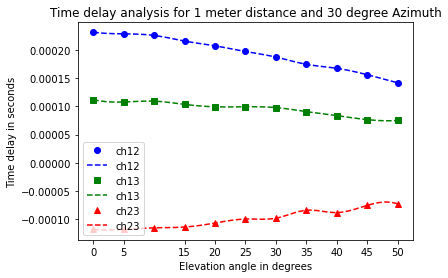

In [9]:
# For 1 Meter Azimuth 30 (all evelations)

index = directorySound_content.index('1Meter_Azimuth30_Elevations')

_1MeterFolderPathAz30 = (os.path.join(directorySound.decode("utf-8"),directorySound_content[index] ))

_1MeterFolderPathAz30_content = os.listdir(_1MeterFolderPathAz30)

Angle = []
TimeDelay_ch12 = []
TimeDelay_ch13 = []
TimeDelay_ch23 = []

#for i in range(0,len(_1MeterFolderPathElv3_content)):
for i in range(0,len(_1MeterFolderPathAz30_content)):
    subdir = (os.path.join(_1MeterFolderPathAz30,_1MeterFolderPathAz30_content[i]))
    #print(subdir)
    with open(os.path.join(subdir,'angle.txt')) as f:
        read_data = f.read()
    Angle.append(int(read_data[0:-1]))
    
    #Read the audio files
    ch1, sfreq = lr.load(os.path.join(subdir, 'ch1.wav'), sr=44100)
    ch2, sfreq = lr.load(os.path.join(subdir, 'ch2.wav'), sr=44100)
    ch3, sfreq = lr.load(os.path.join(subdir, 'ch3.wav'), sr=44100)
       
    ###### Calculate time delay between channel 1 and channel 2
    y1 = ch1
    y2 = ch2
    tau_gcc_12, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch12.append(tau_gcc_12)
    
    ###### Calcualte time delay between channel 1 and channel 3
    y1 = ch1
    y2 = ch3
    tau_gcc_13, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch13.append(tau_gcc_13)
    
    # Calculate time delay between channel 2 and channel 3
    y1 = ch2
    y2 = ch3
    tau_gcc_23, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch23.append(tau_gcc_23)
    
print(Angle)
print(TimeDelay_ch12)
print(TimeDelay_ch13)
print(TimeDelay_ch23)


TimeDelay_ch12_interpolate = interp1d(Angle, TimeDelay_ch12, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch12, 'bo', Angle_interpolate,TimeDelay_ch12_interpolate(Angle_interpolate), 'b--' , label="ch12")
plt.xticks([0,5,10,15,20,25,30,35,40,45,50])   

TimeDelay_ch13_interpolate = interp1d(Angle, TimeDelay_ch13, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch13, 'gs', Angle_interpolate,TimeDelay_ch13_interpolate(Angle_interpolate), 'g--', label = "ch13")

TimeDelay_ch23_interpolate = interp1d(Angle, TimeDelay_ch23, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch23, 'r^', Angle_interpolate,TimeDelay_ch23_interpolate(Angle_interpolate), 'r--', label="ch23")

plt.xlabel('Elevation angle in degrees')
plt.ylabel('Time delay in seconds')
plt.title('Time delay analysis for 1 meter distance and 30 degree Azimuth')
plt.legend()


[40, 25, 0, 35, 5, 50, 20, 10, 45, 15, 30]
[0.0001913265306122449, 0.0002281746031746032, 0.0002735260770975057, 0.00020691609977324264, 0.00026785714285714287, 0.00015873015873015873, 0.0002395124716553288, 0.00025935374149659864, 0.00018140589569160998, 0.00025226757369614514, 0.00022108843537414966]
[0.0001445578231292517, 0.00017857142857142857, 0.00020124716553287982, 0.00015589569160997732, 0.00019982993197278912, 0.00012046485260770975, 0.00018140589569160998, 0.0001969954648526077, 0.00013747165532879818, 0.0001913265306122449, 0.00016865079365079366]
[-4.5351473922902495e-05, -5.102040816326531e-05, -7.511337868480725e-05, -4.67687074829932e-05, -6.944444444444444e-05, -3.401360544217687e-05, -6.094104308390023e-05, -5.9523809523809524e-05, -4.109977324263039e-05, -6.235827664399093e-05, -5.102040816326531e-05]


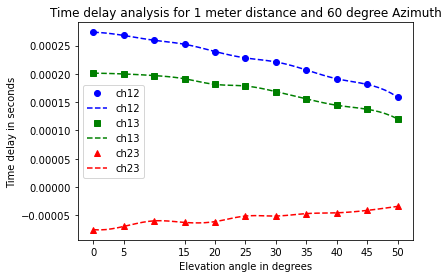

In [5]:
# For 1 Meter Azimuth 60 (all evelations)

index = directorySound_content.index('1Meter_Azimuth60_Elevations')

_1MeterFolderPathAz60 = (os.path.join(directorySound.decode("utf-8"),directorySound_content[index] ))

_1MeterFolderPathAz60_content = os.listdir(_1MeterFolderPathAz60)

Angle = []
TimeDelay_ch12 = []
TimeDelay_ch13 = []
TimeDelay_ch23 = []

for i in range(0,len(_1MeterFolderPathAz60_content)):
    subdir = (os.path.join(_1MeterFolderPathAz60,_1MeterFolderPathAz60_content[i]))
    #print(subdir)
    with open(os.path.join(subdir,'angle.txt')) as f:
        read_data = f.read()
    Angle.append(int(read_data[0:-1]))
    
    #Read the audio files
    ch1, sfreq = lr.load(os.path.join(subdir, 'ch1.wav'), sr=44100)
    ch2, sfreq = lr.load(os.path.join(subdir, 'ch2.wav'), sr=44100)
    ch3, sfreq = lr.load(os.path.join(subdir, 'ch3.wav'), sr=44100)
       
    ###### Calculate time delay between channel 1 and channel 2
    y1 = ch1
    y2 = ch2
    tau_gcc_12, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch12.append(tau_gcc_12)
    
    ###### Calcualte time delay between channel 1 and channel 3
    y1 = ch1
    y2 = ch3
    tau_gcc_13, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch13.append(tau_gcc_13)
    
    # Calculate time delay between channel 2 and channel 3
    y1 = ch2
    y2 = ch3
    tau_gcc_23, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch23.append(tau_gcc_23)
    
print(Angle)
print(TimeDelay_ch12)
print(TimeDelay_ch13)
print(TimeDelay_ch23)


TimeDelay_ch12_interpolate = interp1d(Angle, TimeDelay_ch12, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch12, 'bo', Angle_interpolate,TimeDelay_ch12_interpolate(Angle_interpolate), 'b--' , label="ch12")
plt.xticks([0,5,10,15,20,25,30,35,40,45,50])   

TimeDelay_ch13_interpolate = interp1d(Angle, TimeDelay_ch13, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch13, 'gs', Angle_interpolate,TimeDelay_ch13_interpolate(Angle_interpolate), 'g--', label = "ch13")

TimeDelay_ch23_interpolate = interp1d(Angle, TimeDelay_ch23, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch23, 'r^', Angle_interpolate,TimeDelay_ch23_interpolate(Angle_interpolate), 'r--', label="ch23")

plt.xlabel('Elevation angle in degrees')
plt.ylabel('Time delay in seconds')
plt.title('Time delay analysis for 1 meter distance and 60 degree Azimuth')
plt.legend()


[40, 25, 0, 35, 5, 50, 20, 10, 45, 15, 30]
[7.936507936507937e-05, 9.63718820861678e-05, 0.00012329931972789116, 9.070294784580499e-05, 0.00012046485260770975, 6.519274376417233e-05, 9.92063492063492e-05, 0.00012046485260770975, 7.936507936507937e-05, 0.00010487528344671201, 9.070294784580499e-05]
[0.0001403061224489796, 0.00016723356009070296, 0.00019982993197278912, 0.0001502267573696145, 0.0001927437641723356, 0.00011196145124716554, 0.00016865079365079366, 0.0001927437641723356, 0.00013463718820861677, 0.00018140589569160998, 0.0001530612244897959]
[5.810657596371882e-05, 7.086167800453515e-05, 7.936507936507937e-05, 5.9523809523809524e-05, 7.086167800453515e-05, 4.96031746031746e-05, 7.086167800453515e-05, 7.086167800453515e-05, 5.2437641723356006e-05, 7.086167800453515e-05, 6.235827664399093e-05]


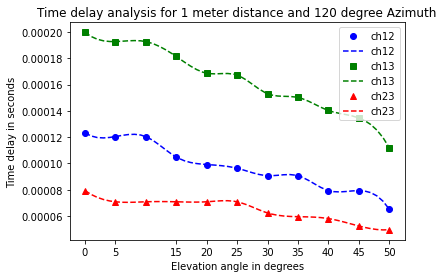

In [5]:
# For 1 Meter Azimuth 120 (all evelations)

index = directorySound_content.index('1Meter_Azimuth120_Elevations')

_1MeterFolderPathAz120 = (os.path.join(directorySound.decode("utf-8"),directorySound_content[index] ))

_1MeterFolderPathAz120_content = os.listdir(_1MeterFolderPathAz120)

Angle = []
TimeDelay_ch12 = []
TimeDelay_ch13 = []
TimeDelay_ch23 = []

for i in range(0,len(_1MeterFolderPathAz120_content)):
    subdir = (os.path.join(_1MeterFolderPathAz120,_1MeterFolderPathAz120_content[i]))
    #print(subdir)
    with open(os.path.join(subdir,'angle.txt')) as f:
        read_data = f.read()
    Angle.append(int(read_data[0:-1]))
    
    #Read the audio files
    ch1, sfreq = lr.load(os.path.join(subdir, 'ch1.wav'), sr=44100)
    ch2, sfreq = lr.load(os.path.join(subdir, 'ch2.wav'), sr=44100)
    ch3, sfreq = lr.load(os.path.join(subdir, 'ch3.wav'), sr=44100)
       
    ###### Calculate time delay between channel 1 and channel 2
    y1 = ch1
    y2 = ch2
    tau_gcc_12, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch12.append(tau_gcc_12)
    
    ###### Calcualte time delay between channel 1 and channel 3
    y1 = ch1
    y2 = ch3
    tau_gcc_13, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch13.append(tau_gcc_13)
    
    # Calculate time delay between channel 2 and channel 3
    y1 = ch2
    y2 = ch3
    tau_gcc_23, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch23.append(tau_gcc_23)
    
print(Angle)
print(TimeDelay_ch12)
print(TimeDelay_ch13)
print(TimeDelay_ch23)


TimeDelay_ch12_interpolate = interp1d(Angle, TimeDelay_ch12, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch12, 'bo', Angle_interpolate,TimeDelay_ch12_interpolate(Angle_interpolate), 'b--' , label="ch12")
plt.xticks([0,5,10,15,20,25,30,35,40,45,50])   

TimeDelay_ch13_interpolate = interp1d(Angle, TimeDelay_ch13, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch13, 'gs', Angle_interpolate,TimeDelay_ch13_interpolate(Angle_interpolate), 'g--', label = "ch13")

TimeDelay_ch23_interpolate = interp1d(Angle, TimeDelay_ch23, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch23, 'r^', Angle_interpolate,TimeDelay_ch23_interpolate(Angle_interpolate), 'r--', label="ch23")

plt.xlabel('Elevation angle in degrees')
plt.ylabel('Time delay in seconds')
plt.title('Time delay analysis for 1 meter distance and 120 degree Azimuth')
plt.legend()

[40, 25, 0, 35, 5, 50, 20, 10, 45, 15, 30]
[-9.92063492063492e-06, -5.668934240362812e-06, -8.503401360544217e-06, -8.503401360544217e-06, -1.2755102040816327e-05, -5.668934240362812e-06, -5.668934240362812e-06, -9.92063492063492e-06, -5.668934240362812e-06, -8.503401360544217e-06, -7.086167800453515e-06]
[8.078231292517007e-05, 9.495464852607709e-05, 0.00010770975056689342, 8.361678004535148e-05, 0.00010487528344671201, 6.944444444444444e-05, 0.00010345804988662132, 9.77891156462585e-05, 7.227891156462585e-05, 0.00010487528344671201, 9.070294784580499e-05]
[9.070294784580499e-05, 0.00010204081632653062, 0.00011904761904761905, 9.495464852607709e-05, 0.00011763038548752834, 7.511337868480725e-05, 0.00010912698412698413, 0.00011196145124716554, 8.078231292517007e-05, 0.00011196145124716554, 0.00010062358276643991]


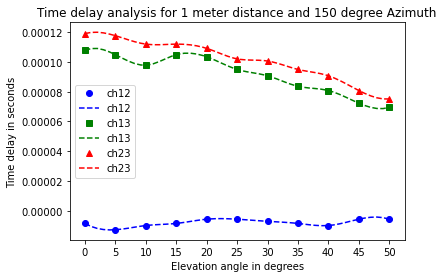

In [5]:
# For 1 Meter Azimuth 150 (all evelations)

index = directorySound_content.index('1Meter_Azimuth150_Elevations')

_1MeterFolderPathAz150 = (os.path.join(directorySound.decode("utf-8"),directorySound_content[index] ))

_1MeterFolderPathAz150_content = os.listdir(_1MeterFolderPathAz150)

Angle = []
TimeDelay_ch12 = []
TimeDelay_ch13 = []
TimeDelay_ch23 = []

for i in range(0,len(_1MeterFolderPathAz150_content)):
    subdir = (os.path.join(_1MeterFolderPathAz150,_1MeterFolderPathAz150_content[i]))
    #print(subdir)
    with open(os.path.join(subdir,'angle.txt')) as f:
        read_data = f.read()
    Angle.append(int(read_data[0:-1]))
    
    #Read the audio files
    ch1, sfreq = lr.load(os.path.join(subdir, 'ch1.wav'), sr=44100)
    ch2, sfreq = lr.load(os.path.join(subdir, 'ch2.wav'), sr=44100)
    ch3, sfreq = lr.load(os.path.join(subdir, 'ch3.wav'), sr=44100)
       
    ###### Calculate time delay between channel 1 and channel 2
    y1 = ch1
    y2 = ch2
    tau_gcc_12, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch12.append(tau_gcc_12)
    
    ###### Calcualte time delay between channel 1 and channel 3
    y1 = ch1
    y2 = ch3
    tau_gcc_13, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch13.append(tau_gcc_13)
    
    # Calculate time delay between channel 2 and channel 3
    y1 = ch2
    y2 = ch3
    tau_gcc_23, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch23.append(tau_gcc_23)
    
print(Angle)
print(TimeDelay_ch12)
print(TimeDelay_ch13)
print(TimeDelay_ch23)


TimeDelay_ch12_interpolate = interp1d(Angle, TimeDelay_ch12, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch12, 'bo', Angle_interpolate,TimeDelay_ch12_interpolate(Angle_interpolate), 'b--' , label="ch12")
plt.xticks([0,5,10,15,20,25,30,35,40,45,50])   

TimeDelay_ch13_interpolate = interp1d(Angle, TimeDelay_ch13, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch13, 'gs', Angle_interpolate,TimeDelay_ch13_interpolate(Angle_interpolate), 'g--', label = "ch13")

TimeDelay_ch23_interpolate = interp1d(Angle, TimeDelay_ch23, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch23, 'r^', Angle_interpolate,TimeDelay_ch23_interpolate(Angle_interpolate), 'r--', label="ch23")

plt.xlabel('Elevation angle in degrees')
plt.ylabel('Time delay in seconds')
plt.title('Time delay analysis for 1 meter distance and 150 degree Azimuth')
plt.legend()

[40, 25, 0, 35, 5, 50, 20, 10, 45, 15, 30]
[-0.0001856575963718821, -0.00021825396825396825, -0.0002451814058956916, -0.0001913265306122449, -0.0002409297052154195, -0.00015447845804988662, -0.00022250566893424037, -0.0002366780045351474, -0.00016298185941043084, -0.0002281746031746032, -0.00020549886621315194]
[-9.92063492063492e-05, -0.00011479591836734693, -0.00013180272108843536, -0.00010204081632653062, -0.00013038548752834466, -8.078231292517007e-05, -0.00011479591836734693, -0.00012613378684807257, -7.511337868480725e-05, -0.00012188208616780046, -0.00010487528344671201]
[8.786848072562358e-05, 0.00010062358276643991, 0.00011196145124716554, 9.21201814058957e-05, 0.00011054421768707483, 7.794784580498866e-05, 0.00010770975056689342, 0.00011196145124716554, 8.503401360544217e-05, 0.00011054421768707483, 0.00010062358276643991]


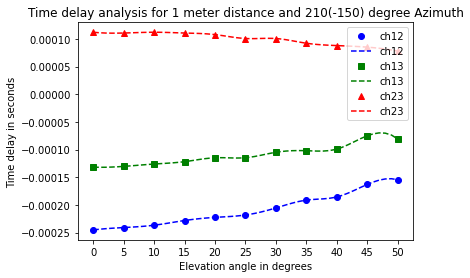

In [5]:
# For 1 Meter Azimuth 210 (-150) (all evelations)

index = directorySound_content.index('1Meter_Azimuth210_Elevations')

_1MeterFolderPathAz210 = (os.path.join(directorySound.decode("utf-8"),directorySound_content[index] ))

_1MeterFolderPathAz210_content = os.listdir(_1MeterFolderPathAz210)

Angle = []
TimeDelay_ch12 = []
TimeDelay_ch13 = []
TimeDelay_ch23 = []

for i in range(0,len(_1MeterFolderPathAz210_content)):
    subdir = (os.path.join(_1MeterFolderPathAz210,_1MeterFolderPathAz210_content[i]))
    #print(subdir)
    with open(os.path.join(subdir,'angle.txt')) as f:
        read_data = f.read()
    Angle.append(int(read_data[0:-1]))
    
    #Read the audio files
    ch1, sfreq = lr.load(os.path.join(subdir, 'ch1.wav'), sr=44100)
    ch2, sfreq = lr.load(os.path.join(subdir, 'ch2.wav'), sr=44100)
    ch3, sfreq = lr.load(os.path.join(subdir, 'ch3.wav'), sr=44100)
       
    ###### Calculate time delay between channel 1 and channel 2
    y1 = ch1
    y2 = ch2
    tau_gcc_12, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch12.append(tau_gcc_12)
    
    ###### Calcualte time delay between channel 1 and channel 3
    y1 = ch1
    y2 = ch3
    tau_gcc_13, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch13.append(tau_gcc_13)
    
    # Calculate time delay between channel 2 and channel 3
    y1 = ch2
    y2 = ch3
    tau_gcc_23, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch23.append(tau_gcc_23)
    
print(Angle)
print(TimeDelay_ch12)
print(TimeDelay_ch13)
print(TimeDelay_ch23)


TimeDelay_ch12_interpolate = interp1d(Angle, TimeDelay_ch12, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch12, 'bo', Angle_interpolate,TimeDelay_ch12_interpolate(Angle_interpolate), 'b--' , label="ch12")
plt.xticks([0,5,10,15,20,25,30,35,40,45,50])   

TimeDelay_ch13_interpolate = interp1d(Angle, TimeDelay_ch13, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch13, 'gs', Angle_interpolate,TimeDelay_ch13_interpolate(Angle_interpolate), 'g--', label = "ch13")

TimeDelay_ch23_interpolate = interp1d(Angle, TimeDelay_ch23, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch23, 'r^', Angle_interpolate,TimeDelay_ch23_interpolate(Angle_interpolate), 'r--', label="ch23")

plt.xlabel('Elevation angle in degrees')
plt.ylabel('Time delay in seconds')
plt.title('Time delay analysis for 1 meter distance and 210(-150) degree Azimuth')
plt.legend()

[40, 25, 0, 35, 5, 50, 20, 10, 45, 15, 30]
[-0.00020833333333333335, -0.0002409297052154195, -0.0002777777777777778, -0.00022108843537414966, -0.0002763605442176871, -0.00017290249433106575, -0.00025226757369614514, -0.0002735260770975057, -0.0001927437641723356, -0.00026785714285714287, -0.00023242630385487528]
[-0.00015731292517006803, -0.00018282312925170069, -0.00021967120181405896, -0.00016439909297052155, -0.00021116780045351473, -0.00012471655328798187, -0.0001927437641723356, -0.00020691609977324264, -0.0001417233560090703, -0.00020266439909297053, -0.00017573696145124716]
[5.102040816326531e-05, 5.9523809523809524e-05, 6.094104308390023e-05, 5.668934240362812e-05, 6.377551020408164e-05, 4.393424036281179e-05, 5.9523809523809524e-05, 6.519274376417233e-05, 4.96031746031746e-05, 6.377551020408164e-05, 5.810657596371882e-05]


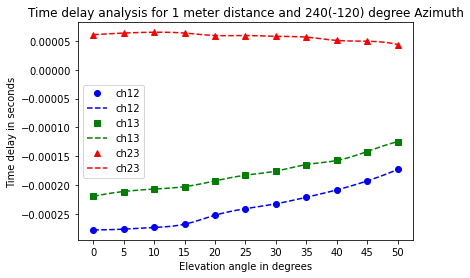

In [4]:
# For 1 Meter Azimuth 240 (-120) (all evelations)

index = directorySound_content.index('1Meter_Azimuth240_Elevations')

_1MeterFolderPathAz240 = (os.path.join(directorySound.decode("utf-8"),directorySound_content[index] ))

_1MeterFolderPathAz240_content = os.listdir(_1MeterFolderPathAz240)

Angle = []
TimeDelay_ch12 = []
TimeDelay_ch13 = []
TimeDelay_ch23 = []

for i in range(0,len(_1MeterFolderPathAz240_content)):
    subdir = (os.path.join(_1MeterFolderPathAz240,_1MeterFolderPathAz240_content[i]))
    #print(subdir)
    with open(os.path.join(subdir,'angle.txt')) as f:
        read_data = f.read()
    Angle.append(int(read_data[0:-1]))
    
    #Read the audio files
    ch1, sfreq = lr.load(os.path.join(subdir, 'ch1.wav'), sr=44100)
    ch2, sfreq = lr.load(os.path.join(subdir, 'ch2.wav'), sr=44100)
    ch3, sfreq = lr.load(os.path.join(subdir, 'ch3.wav'), sr=44100)
       
    ###### Calculate time delay between channel 1 and channel 2
    y1 = ch1
    y2 = ch2
    tau_gcc_12, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch12.append(tau_gcc_12)
    
    ###### Calcualte time delay between channel 1 and channel 3
    y1 = ch1
    y2 = ch3
    tau_gcc_13, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch13.append(tau_gcc_13)
    
    # Calculate time delay between channel 2 and channel 3
    y1 = ch2
    y2 = ch3
    tau_gcc_23, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch23.append(tau_gcc_23)
    
print(Angle)
print(TimeDelay_ch12)
print(TimeDelay_ch13)
print(TimeDelay_ch23)


TimeDelay_ch12_interpolate = interp1d(Angle, TimeDelay_ch12, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch12, 'bo', Angle_interpolate,TimeDelay_ch12_interpolate(Angle_interpolate), 'b--' , label="ch12")
plt.xticks([0,5,10,15,20,25,30,35,40,45,50])   

TimeDelay_ch13_interpolate = interp1d(Angle, TimeDelay_ch13, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch13, 'gs', Angle_interpolate,TimeDelay_ch13_interpolate(Angle_interpolate), 'g--', label = "ch13")

TimeDelay_ch23_interpolate = interp1d(Angle, TimeDelay_ch23, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch23, 'r^', Angle_interpolate,TimeDelay_ch23_interpolate(Angle_interpolate), 'r--', label="ch23")

plt.xlabel('Elevation angle in degrees')
plt.ylabel('Time delay in seconds')
plt.title('Time delay analysis for 1 meter distance and 240(-120) degree Azimuth')
plt.legend()

[40, 25, 0, 35, 5, 50, 20, 10, 45, 15, 30]
[-0.00010062358276643991, -0.00011904761904761905, -0.00013038548752834466, -0.00010487528344671201, -0.00013180272108843536, -8.503401360544217e-05, -0.00011904761904761905, -0.00013038548752834466, -9.63718820861678e-05, -0.00012896825396825398, -0.00010770975056689342]
[-0.0001530612244897959, -0.00018990929705215418, -0.00021258503401360543, -0.00016581632653061225, -0.00021116780045351473, -0.00013180272108843536, -0.0001927437641723356, -0.00020975056689342402, -0.0001459750566893424, -0.00019982993197278912, -0.00017857142857142857]
[-5.668934240362812e-05, -6.944444444444444e-05, -8.219954648526077e-05, -6.094104308390023e-05, -7.794784580498866e-05, -4.5351473922902495e-05, -7.511337868480725e-05, -7.511337868480725e-05, -5.5272108843537416e-05, -7.653061224489796e-05, -6.519274376417233e-05]


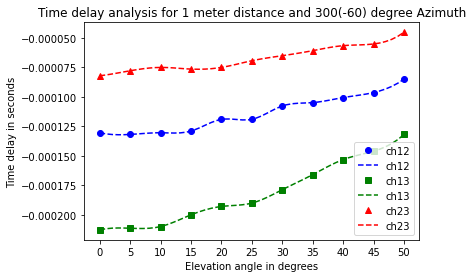

In [4]:
# For 1 Meter Azimuth 300 (-60) (all evelations)

index = directorySound_content.index('1Meter_Azimuth300_Elevations')

_1MeterFolderPathAz300 = (os.path.join(directorySound.decode("utf-8"),directorySound_content[index] ))

_1MeterFolderPathAz300_content = os.listdir(_1MeterFolderPathAz300)

Angle = []
TimeDelay_ch12 = []
TimeDelay_ch13 = []
TimeDelay_ch23 = []

for i in range(0,len(_1MeterFolderPathAz300_content)):
    subdir = (os.path.join(_1MeterFolderPathAz300,_1MeterFolderPathAz300_content[i]))
    #print(subdir)
    with open(os.path.join(subdir,'angle.txt')) as f:
        read_data = f.read()
    Angle.append(int(read_data[0:-1]))
    
    #Read the audio files
    ch1, sfreq = lr.load(os.path.join(subdir, 'ch1.wav'), sr=44100)
    ch2, sfreq = lr.load(os.path.join(subdir, 'ch2.wav'), sr=44100)
    ch3, sfreq = lr.load(os.path.join(subdir, 'ch3.wav'), sr=44100)
       
    ###### Calculate time delay between channel 1 and channel 2
    y1 = ch1
    y2 = ch2
    tau_gcc_12, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch12.append(tau_gcc_12)
    
    ###### Calcualte time delay between channel 1 and channel 3
    y1 = ch1
    y2 = ch3
    tau_gcc_13, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch13.append(tau_gcc_13)
    
    # Calculate time delay between channel 2 and channel 3
    y1 = ch2
    y2 = ch3
    tau_gcc_23, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch23.append(tau_gcc_23)
    
print(Angle)
print(TimeDelay_ch12)
print(TimeDelay_ch13)
print(TimeDelay_ch23)


TimeDelay_ch12_interpolate = interp1d(Angle, TimeDelay_ch12, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch12, 'bo', Angle_interpolate,TimeDelay_ch12_interpolate(Angle_interpolate), 'b--' , label="ch12")
plt.xticks([0,5,10,15,20,25,30,35,40,45,50])   

TimeDelay_ch13_interpolate = interp1d(Angle, TimeDelay_ch13, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch13, 'gs', Angle_interpolate,TimeDelay_ch13_interpolate(Angle_interpolate), 'g--', label = "ch13")

TimeDelay_ch23_interpolate = interp1d(Angle, TimeDelay_ch23, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch23, 'r^', Angle_interpolate,TimeDelay_ch23_interpolate(Angle_interpolate), 'r--', label="ch23")

plt.xlabel('Elevation angle in degrees')
plt.ylabel('Time delay in seconds')
plt.title('Time delay analysis for 1 meter distance and 300(-60) degree Azimuth')
plt.legend()

[40, 25, 0, 35, 5, 50, 20, 10, 45, 15, 30]
[-1.417233560090703e-06, 2.834467120181406e-06, -4.251700680272109e-06, -2.834467120181406e-06, -1.417233560090703e-06, -9.92063492063492e-06, -5.668934240362812e-06, -1.417233560090703e-06, -7.086167800453515e-06, -2.834467120181406e-06, -5.668934240362812e-06]
[-9.21201814058957e-05, -0.00010345804988662132, -0.00013463718820861677, -9.77891156462585e-05, -0.00012896825396825398, -8.078231292517007e-05, -0.00012046485260770975, -0.00012471655328798187, -8.786848072562358e-05, -0.00012046485260770975, -0.00010629251700680272]
[-9.070294784580499e-05, -0.00010770975056689342, -8.645124716553288e-05, -9.495464852607709e-05, -0.00012755102040816328, -7.511337868480725e-05, -0.00011054421768707483, -0.00012188208616780046, -7.794784580498866e-05, -0.00011621315192743764, -0.00010345804988662132]


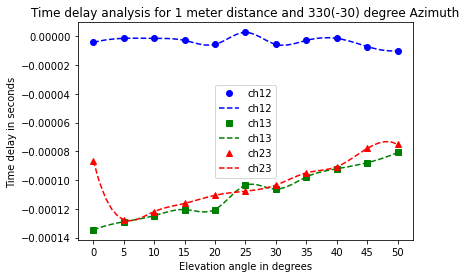

In [4]:
# For 1 Meter Azimuth 330 (-30) (all evelations)

index = directorySound_content.index('1Meter_Azimuth330_Elevations')

_1MeterFolderPathAz330 = (os.path.join(directorySound.decode("utf-8"),directorySound_content[index] ))

_1MeterFolderPathAz330_content = os.listdir(_1MeterFolderPathAz330)

Angle = []
TimeDelay_ch12 = []
TimeDelay_ch13 = []
TimeDelay_ch23 = []

for i in range(0,len(_1MeterFolderPathAz330_content)):
    subdir = (os.path.join(_1MeterFolderPathAz330,_1MeterFolderPathAz330_content[i]))
    #print(subdir)
    with open(os.path.join(subdir,'angle.txt')) as f:
        read_data = f.read()
    Angle.append(int(read_data[0:-1]))
    
    #Read the audio files
    ch1, sfreq = lr.load(os.path.join(subdir, 'ch1.wav'), sr=44100)
    ch2, sfreq = lr.load(os.path.join(subdir, 'ch2.wav'), sr=44100)
    ch3, sfreq = lr.load(os.path.join(subdir, 'ch3.wav'), sr=44100)
       
    ###### Calculate time delay between channel 1 and channel 2
    y1 = ch1
    y2 = ch2
    tau_gcc_12, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch12.append(tau_gcc_12)
    
    ###### Calcualte time delay between channel 1 and channel 3
    y1 = ch1
    y2 = ch3
    tau_gcc_13, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch13.append(tau_gcc_13)
    
    # Calculate time delay between channel 2 and channel 3
    y1 = ch2
    y2 = ch3
    tau_gcc_23, cc = gcc_phat(y2,y1,sfreq)
    TimeDelay_ch23.append(tau_gcc_23)
    
print(Angle)
print(TimeDelay_ch12)
print(TimeDelay_ch13)
print(TimeDelay_ch23)


TimeDelay_ch12_interpolate = interp1d(Angle, TimeDelay_ch12, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch12, 'bo', Angle_interpolate,TimeDelay_ch12_interpolate(Angle_interpolate), 'b--' , label="ch12")
plt.xticks([0,5,10,15,20,25,30,35,40,45,50])   

TimeDelay_ch13_interpolate = interp1d(Angle, TimeDelay_ch13, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch13, 'gs', Angle_interpolate,TimeDelay_ch13_interpolate(Angle_interpolate), 'g--', label = "ch13")

TimeDelay_ch23_interpolate = interp1d(Angle, TimeDelay_ch23, kind='cubic')
Angle_interpolate = np.linspace(0, 50, num=50, endpoint=True)
plt.plot(Angle, TimeDelay_ch23, 'r^', Angle_interpolate,TimeDelay_ch23_interpolate(Angle_interpolate), 'r--', label="ch23")

plt.xlabel('Elevation angle in degrees')
plt.ylabel('Time delay in seconds')
plt.title('Time delay analysis for 1 meter distance and 330(-30) degree Azimuth')
plt.legend()